In [107]:
import numpy as np
import matplotlib.pyplot as plt
import random

### There are various package to do ML.

I'm using TensorFlow, which is I think the easiest (not necessarily the best regarding comprehension and debugging) https://www.tensorflow.org/

For more lowlevel, you can use Torch (or PyTorch). 

For Bayesian models, or when you want to do complex stuff regarding gradient descent, matrix incersion or else, (or even more classic ML), the one who's groing a lot these days is JaX (https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)



In [108]:
import tensorflow as tf
print(tf.__version__)

2.17.0


I'm also using a lot a subpackage of tf, called Keras (it was previously two different packages, with tf being a lower level API and Keras being very user friendly, but they merged in tensorflow 2.1).

It's the easiest API to use, and you can even do complex things. This is what I use the most. Nevertheless, if you want to really understand what is going on, it's good to start learning with pure tensorflow, where you define more manually what you're doing. 

You can also use a bit of both now that it's the same API, and take the best of both worlds!

That what we will be doing here

In [109]:
from tensorflow import keras as tfk

## The Problem

Let's define a very simple task : fit a linear problem.

We have slope, $a=2$, and an intercept $b=5$. Our data points, {$y_i$} follow $y_i=ax_i+b$, where {$x_i$} range from $0$ to $4$.

To make the task a bit harder, we add a white noise of dispersion $\sigma=0.1$

In [110]:
a, b = 2, 5
sigma = 0.1

'linear range of values betwwen 0.2 and 0.8, 5000 points'
xs = np.linspace(0.2, 0.8, 5000)

'5000 random values following a normal distrbution (mean=0, sigma=0.1)'
rdms = np.random.normal(0, sigma, len(xs))

ys = (a * xs + b + rdms)

### Data Viz
We also show the "true regression", i.e. the regression with no noise

Text(0.5, 1.0, 'Training data (not all)')

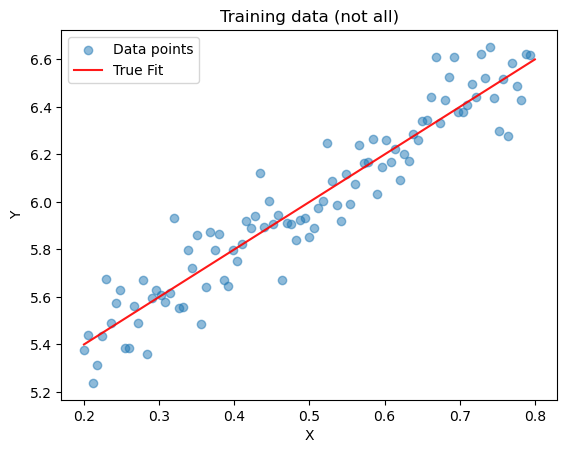

In [111]:
'We show only 1/50 of the points to not have a too crawded plot'
plt.scatter(xs[::50], ys[::50], alpha=0.5, label='Data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot([xs[0], xs[-1]], [a*xs[0]+b, a*xs[-1]+b], alpha=0.9, label='True Fit', color='red')
plt.legend()
plt.title('Training data (not all)')

## Now, let's prepare our data to work with a simple neural network :
We first shuffle the data. by using a fixed seed (4), we ensure that the x and y are shuffle the same way

In [112]:
print(f'x before shuffle, {xs[:5]}')
print(f'y before shuffle, {ys[:5]}')
random.Random(4).shuffle(xs)
random.Random(4).shuffle(ys)
print(f'\n x after shuffle, {xs[:5]}')
print(f'y after shuffle, {ys[:5]}')

x before shuffle, [0.2        0.20012002 0.20024005 0.20036007 0.2004801 ]
y before shuffle, [5.37752123 5.5586237  5.52162493 5.32400821 5.40909788]

 x after shuffle, [0.37523505 0.55515103 0.59103821 0.64624925 0.36647329]
y after shuffle, [5.85133851 6.13870605 6.30974632 6.34615667 5.72451142]


Machine learning algorithms usually learn from a batch of image at a time (not all image, nor one). 

Thus we need to create the batches, i.e. transforming our 5000 data points in $n$ batch.

We are training on 80% of the dataset, the 20% left being used for testing the trained model:


In [113]:
batch_size = 32
nb_batch_train = int((0.8*len(xs)) // batch_size)
print('number of batches for training:', nb_batch_train)

number of batches for training: 125


We first create an empty array of the good dimension:


In [114]:
X_train = np.zeros((nb_batch_train, batch_size))
Y_train = np.zeros((nb_batch_train, batch_size))
X_test = np.zeros((1, batch_size))
Y_test = np.zeros((1, batch_size))
print('X train shape: ', np.shape(X_train))
print('Y train shape: ', np.shape(Y_train))
print('X test shape: ', np.shape(X_train))
print('Y test shape: ', np.shape(Y_train))

X train shape:  (125, 32)
Y train shape:  (125, 32)
X test shape:  (125, 32)
Y test shape:  (125, 32)


And we then populate the arrays with the training data:

In [115]:
for i in range(nb_batch_train):
    X_train[i, :] = xs[i*batch_size: (i+1)*batch_size]
    Y_train[i, :] = ys[i*batch_size: (i+1)*batch_size]
X_test[0, :] = xs[-batch_size:]
Y_test[0, :] = ys[-batch_size:]


Finally, we need to add the `feature` dimension: a deep learning model is usualy learning different representation of the data, which are called feature. Even if we have just one, keras needs this extra dimension to work.

A good way to visualize what a features is is with images: if you have a black and white image, you have for example a $(128\times128)$ matrix.

If you have a RGB image, you will have a $(128\times128\times3)$ tensor.

You can see the gray image as a $(128\times128\times1)$ image, i.e. a tensor with just one dimension in the $z$ axis.

Here, we are transforming a scalar to a tensor of dimension (1, 1). And because we are using batch, we have the following dimension:



In [116]:
' Adding the channel dimension'
X_train = np.expand_dims(X_train, -1)
Y_train = np.expand_dims(Y_train, -1)
X_test = np.expand_dims(X_train, -1)
Y_test = np.expand_dims(Y_train, -1)
print('Final shape of the training set', X_train.shape, '125 batches of 32 points of 1 dimension')

Final shape of the training set (125, 32, 1) 125 batches of 32 points of 1 dimension


There is a much faster (and ore efficient) way to create tensorflow datasets, with only one line, but I think it's good at least once to do the different steps yourself.


``` python
# The cleaner and more effective way to create the dataset
training_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(10000).batch(batch_size)

See the tf dataset tutorial for more information. 

Finally, tensorflow likes to work with Tensorflow tensors, so we can transform our numpy array to tensor:

In [117]:
training_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
testing_set = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

## Model

We can know define our model : we just have one dense layer of one weight, $w_1$, and a bias vector of one number, $b_1$. By doing that, our network is doing exactly a linear model : the output of a input point $x_i$ is 

$y_i = w_1x_i + b_1$.

Thus, fitting $w_1$ and $b_1$ by gradient descent will approximate the true $a$ and $b$ from where our data point come from.


It's time to build our first (dummy) model with Keras:
First, we need to tell it what is our input. The keras model API only need to be given the shape of one data point: here (1, 1)
If you were working with an image it would be the shape of the image, e.g. (128, 128, 1) or (128, 128, 3) if it's a color image, or (100, 1) if you were working with 100 genes.

In [118]:
X_in = tfk.Input(shape=(1, 1), dtype=tf.float32)

We have now to define the propoer architecture of the model, i.e. what operations we want to apply to our input to predict our goal, i.e. $y$. As stated before, we are going to use a simple neuron, which is implemented in keras with the `Dense` layer, with 1 node:

In [119]:
Y_out = tfk.layers.Dense(1)(X_in)

Now we define the model, i.e. what is the input and what is the output. the keras API will keep in memory all the information about the intermediate steps if there are, and will be able to compte the gradients, and to adapt the weights.

You should just define what's the input, and what is the output. The other *hyperparameters* such as the loss, the learning rate etc will be defined in your training function


In [120]:
model = tfk.Model(X_in, Y_out, name='neuron')

See what your model looks like with the nice `summary()` method:

In [121]:
model.summary()

Model: "neuron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1, 1)           │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Note the `None` in the shape: tfk models automatically assume that you re going to work with batch

We can also plot the model:

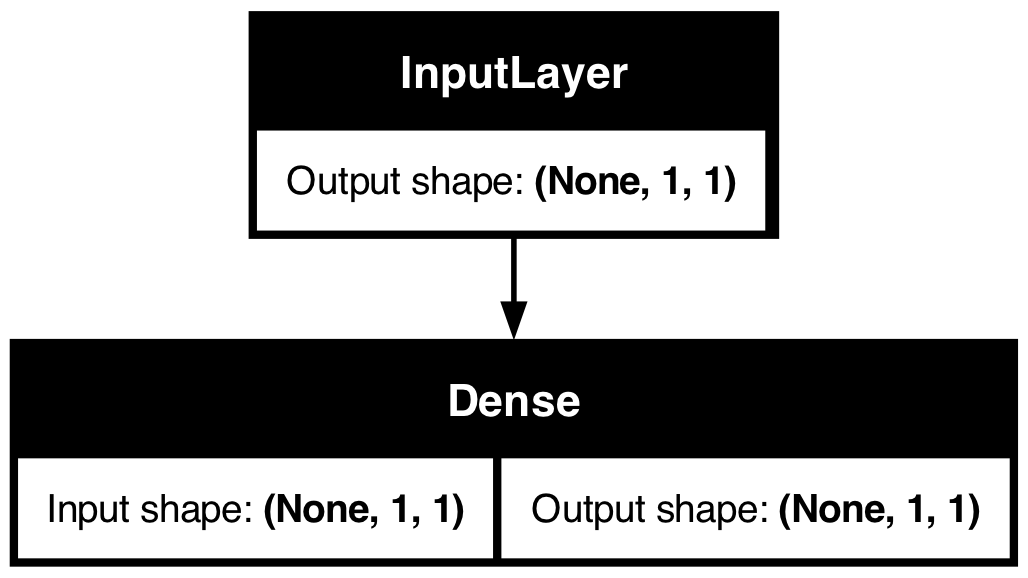

In [122]:
tfk.utils.plot_model(model, 'single_neuron.png', show_shapes=True)

## Training

Now, we can define our training step function (you can check the `model.fit()` [https://keras.io/api/models/model_training_apis/#fit-method] API for a higher level API, but I don't really like it as you really don't manage much yourself):


```python
model.compile('rmsprop', tf.keras.losses.MSE)
hist = model.fit(xs, ys, 32, 100)

I prefer to build my own training function (it s better to understand what is going on, and have much more flexibility when you will create more complex models):

The training function is as follow: 

- Predict the batch by feeding the model a batch input. 
- Compute the gradients of the loss regarding the weights of the model
- Optimize the weights by applying the gradient descent method of your choice (defined by the optimizer)

In [123]:
def train_model(X, Y, loss_fn, optimizer):
    """ with this, tf will automatically record al the info to then compute all gradients and then more the weights with gradient descent """
    with tf.GradientTape() as tape: 
        pred = model(X)
        loss = loss_fn(Y, pred)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return (np.sum(loss.numpy()))  # sum because the loss is computed individually for each instance of the current batch

### ! Advice
Never mix numpy and tensorflow operations. Here it's just to save the value of the loss, it has nothing to do with the model, so it's ok, but otherwise it can create serious problem that are hard to debbug...

We can try to see what our models predict before training: the weights and biases of the neuron (w_1 and b_1) are random, so it should predict for each x some y following a random linear function

In [124]:
training_set

<_TensorSliceDataset element_spec=(TensorSpec(shape=(32, 1), dtype=tf.float64, name=None), TensorSpec(shape=(32, 1), dtype=tf.float64, name=None))>

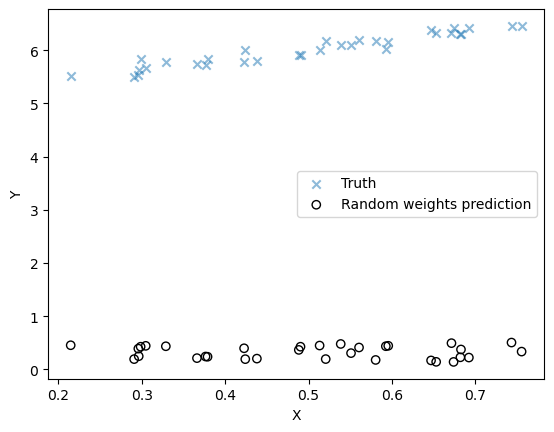

In [125]:
''' Chose random points in the training set'''
rdm_indices = np.random.randint(0, batch_size, batch_size) 

''' Predict the ys by passing the x through our model. Kill after one batch'''
for i, (x_batch, y_batch) in enumerate(training_set):
    if i > 0:
        break
    ys_pred = model(x_batch)

''' Plot the result'''
plt.scatter(x_batch, y_batch, marker='x', alpha=0.5, label='Truth')
plt.scatter(x_batch, ys_pred, marker='o', facecolor='none', edgecolor='black', label='Random weights prediction')
# plt.scatter(xs_plot, a_init*x_test + b_init, ls='-', marker='o', facecolor='none', edgecolor='black', label='Random weights prediction')
# plt.plot(xs, (a*xs + b))
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(fontsize=10)

Let's define the loss, and our optimizer (i.e. how to change the weights of our model regarding the loss)

In my exp, models are not too sensitive to the gradient descent methods.

I usually use Adams, which is a better version of the classic stochastic gradient descent


In [126]:
loss_fn = tfk.losses.MSE # simple mean square error between each x and y
optimizer = tfk.optimizers.SGD(learning_rate=5e-4) # I voluntarily chose a small learning rate because the task is super easy but i want to show the loss decreasing regularly

We can now really train our model: we train for 10 epochs, calling the training function for each batch.

In [127]:
losses = []
nb_epochs = 10

for epoch in range(nb_epochs):
    for x_batch, y_batch in training_set:
        results = train_model(x_batch, y_batch, loss_fn, optimizer)
        losses.append(results)

Let's plot the loss: if our model is training, it should go down with the steps:

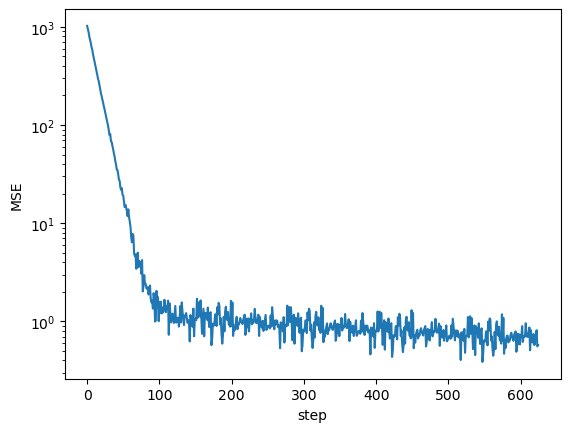

In [135]:
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('MSE')
plt.yscale('log')

In our case, (and it s basically the only case in DL), the weights are interpretable: the way that our architecture is define, the weight whould ve the slope, and the bias the intercept. We can access this:

In [129]:
print(f' w_0 : {model.weights[0].numpy()[0][0]:.3f}, true slope: {a}')
print(f' b_0 : {model.weights[1].numpy()[0]:.3f}, true intercept: {b}')

 w_0 : 2.595, true slope: 2
 b_0 : 4.693, true intercept: 5


Looks great !

### Test the model:



Select the test set, i.e. the points we have not used yet and pass them trough the model:

In [130]:
for x_test, y_test in testing_set:
    y_pred_test = model(x_test)

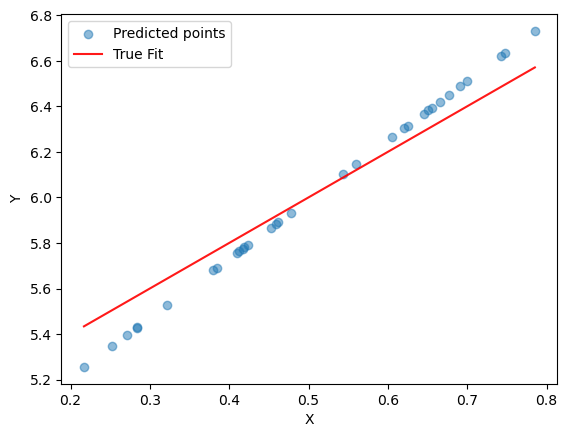

In [134]:
plt.scatter(x_test, y_pred_test, alpha=0.5, label='Predicted points')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot([np.min(x_test), np.max(x_test)], [a*np.min(x_test)+b, a*np.max(x_test)+b], alpha=0.9, label='True Fit', color='red')
plt.legend()
# plt.title('Training data')

In [132]:
ls ../linear_regression/

ls: ../linear_regression/: No such file or directory


In [133]:
from IPython.display import Image
display(Image(data=open('./animation_regression.gif','rb').read(), format='png'))

FileNotFoundError: [Errno 2] No such file or directory: './animation_regression.gif'